In [4]:
import pandas as pd

Author is Marie Tarazi

Run Order is :
Pass 1 -> Pass 2 -> Labels -> Fit -> LOO -> Threshold

# Generating the Weights

In [7]:
#Load markers
df = pd.read_csv("C:/Users/la7me/Downloads/Markers GSE299623 .csv")

In [8]:
df.head()

,Marker,Cell,Group,t-test score
0,TMSB4X,T,Carcinosarcoma,40.52
1,MT-ATP6,T,Carcinosarcoma,40.36
2,MT-ND1,T,Carcinosarcoma,40.30
3,IFI6,T,Carcinosarcoma,39.07
4,RSRP1,T,Normal Endometrial,27.67


In [9]:
#List out the markers
df['Marker'].unique()

array(['TMSB4X', 'MT-ATP6', 'MT-ND1', 'IFI6', 'RSRP1', 'CIRBP', 'ESR1',
       'ARGLU1', 'HMGA2', 'ITM2C', 'MDFI', 'FXYD6', 'PIGR', 'EVL',
       'WFDC2', 'ASRGL1'], dtype=object)

In [10]:
# Pivot the columns to have them organizaed by cell, then disease
pivot = df.pivot_table(index="Marker", columns=["Cell","Group"], values="t-test score", aggfunc="first")

In [11]:
pivot.head()

Cell                B                                 T                   
Group  Carcinosarcoma Normal Endometrial Carcinosarcoma Normal Endometrial
Marker                                                                    
ARGLU1            NaN                NaN            NaN              21.71
ASRGL1            NaN              14.66            NaN                NaN
CIRBP             NaN                NaN            NaN              24.06
ESR1              NaN                NaN            NaN              22.30
EVL               NaN              16.45            NaN                NaN

In [12]:
# DEtect which group is case vs normal
#This can be manually over-ridden if needed
groups = sorted(df["Group"].unique())
case_label = next((g for g in groups if "Carcino" in g or "Cancer" in g or "Tumor" in g), groups[0])
normal_label = next((g for g in groups if "Normal" in g or "Control" in g), groups[-1])

print("Case group:", case_label)
print("Normal group:", normal_label)

Case group: Carcinosarcoma
Normal group: Normal Endometrial


In [13]:
#Build a disease enrichment vector for each cell type
# vector = (case t-score) - (normal t-score)
cells = sorted(df["Cell"].astype(str).unique())
delta_unclipped = pd.DataFrame(index=pivot.index)
'''
    We want weights that emphasize markers within each panel.
    If delta > 0, then more case-like than normal.
'''
for cell in cells:
    col_case = (cell, case_label)
    col_norm = (cell, normal_label)
    if col_case in pivot.columns and col_norm in pivot.columns:
        delta_unclipped[(cell, "delta")] = pivot[col_case].fillna(0) - pivot[col_norm].fillna(0)
    else:
        # If a pair is missing, just fill zeros
        delta_unclipped[(cell, "delta")] = 0.0

In [14]:
#Keep only disease-enriched signal
#Normalize within each cell type so all sum(weights) = 1
weights = delta_unclipped.clip(lower=0).copy()

for col in weights.columns:
    s = weights[col].sum()
    if s > 0:
        weights[col] = weights[col] / s  # column-wise normalization (within-cell)

In the above, we have taken $\Delta w_{cell} (g)=t_{case} - t_{normal}$, clipped the negatively correlated ones to zero, then normalized such that the sums of the weights in each panel sum to 1. The score per cell is $S_T = S_B\sum_g e_T(g) Z_{g,c}$ and are both weighted averages of positive values where $w$ is the weight and $Z$ is the gene score.

In this way, only disease-enriched genes push the score up whereas normal genes are ignored. This method is conservative when unsure about negative signals - we wouldn't get penalized for guessing the wrong sign. Thus, a mis-signed gene won't subtract from the score, just contribute less. Furthermore, each gene's influence is bounded and positive. Finally, stronger evidence in any marker never lowers risk. This is incredibly appealing clinically because it is not possible for the score S to go down when any gene score increases.

This method is preferred if the labels are limited or noisy. Signed weights maintain the direction of each marker, so it's more versatile if we're switching between marker databases or cancer types. Regardless, all the mathematics downstream remains identical since the only thing changing is how the two inputs (patient scores) are built.

In [16]:
#Build per-gene table
out = pd.DataFrame({
    "Marker": delta_unclipped.index,
    "delta_T": delta_unclipped.get(("T","delta"), pd.Series(0.0, index=delta_unclipped.index)),
    "delta_B": delta_unclipped.get(("B","delta"), pd.Series(0.0, index=delta_unclipped.index)),
    "w_T":     weights.get(("T","delta"), pd.Series(0.0, index=weights.index)),
    "w_B":     weights.get(("B","delta"), pd.Series(0.0, index=weights.index)),
}).reset_index(drop=True)

In [17]:
save_path = r"C:\Users\la7me\Downloads\panel_weights_from_markers_csv.csv"
#out.to_csv(save_path, index=False)
print("Saved path:", save_path)
out

Saved path: C:\Users\la7me\Downloads\panel_weights_from_markers_csv.csv


,Marker,delta_T,delta_B,w_T,w_B
0,ARGLU1,-21.71,0.00,0.000000,0.000000
1,ASRGL1,0.00,-14.66,0.000000,0.000000
2,CIRBP,-24.06,0.00,0.000000,0.000000
3,ESR1,-22.30,0.00,0.000000,0.000000
4,EVL,0.00,-16.45,0.000000,0.000000
5,FXYD6,0.00,20.31,0.000000,0.243321
6,HMGA2,0.00,22.13,0.000000,0.265125
7,IFI6,39.07,0.00,0.243807,0.000000
8,ITM2C,0.00,20.58,0.000000,0.246556
9,MDFI,0.00,20.45,0.000000,0.244998


# Patient Risk

At this point, we want to move onto the macroscale - i.e. observing how this affects an individual. Thus, we want to generate two patient-level numbers: $f$ and $\Delta$. The former is the fraction of a patient's cells that look more like T or B cells using the marker panels. The latter is the average of the T vs B numbers across that same patient's cells. 

At the cell level, each cell is scored with the panels -> T score, B score, and difference.
At the patient level, summarize those cell scores into statistics -> $f$, $\Delta$.

Each sample has a 10x triplet: the matrix.mtx files are the counts, the features.tsc are the gene names and serve as rows, and the barcodes.tsv are the cell_IDS and serve as the column. By aligning the gene names, each triplet is read and stitched into a big matrix.

In [20]:
# Load and merge the 10x data
import os, glob,gzip
import numpy as np
from io import BytesIO
from scipy.io import mmread
from scipy.sparse import csr_matrix
#!pip install scanpy anndata'''

In [21]:
# Where your raw triplets are (flat or subfolders; we'll detect both):
PARENT = r"C:\Users\la7me\Downloads\GSE299623_RAW_EXTRACT"
# Your weights file (the one we made from the markers CSV)
WEIGHTS_CSV = r"C:\Users\la7me\Downloads\panel_weights_from_markers_csv.csv"

In [22]:
W = pd.read_csv(WEIGHTS_CSV)
G_T = W.loc[W.w_T>0, "Marker"].astype(str).tolist()
G_B = W.loc[W.w_B>0, "Marker"].astype(str).tolist()
TARGET_GENES = sorted(set(G_T) | set(G_B))
w_T = dict(zip(W["Marker"], W["w_T"]))
w_B = dict(zip(W["Marker"], W["w_B"]))
print("Target genes:", TARGET_GENES)

Target genes: ['FXYD6', 'HMGA2', 'IFI6', 'ITM2C', 'MDFI', 'MT-ATP6', 'MT-ND1', 'TMSB4X']


In [23]:
#Sample Discovery
def list_triplets(parent):
    # returns list of (prefix, mtx_path, features_path, barcodes_path)
    mtxs = sorted(glob.glob(os.path.join(parent, "**", "*_matrix.mtx*"), recursive=True))
    triplets = []
    for mtx in mtxs:
        base = mtx.replace("_matrix.mtx.gz","").replace("_matrix.mtx","")
        feats = base + "_features.tsv"
        bars  = base + "_barcodes.tsv"
        if not os.path.exists(feats) and os.path.exists(feats + ".gz"): feats += ".gz"
        if not os.path.exists(bars)  and os.path.exists(bars + ".gz"):  bars  += ".gz"
        if os.path.exists(feats) and os.path.exists(bars):
            triplets.append((os.path.basename(base), mtx, feats, bars))
    return triplets

triplets = list_triplets(PARENT)
print("Found triplets:", len(triplets))
triplets[:3]

Found triplets: 8


[('GSM9042132_A2_1',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042132_A2_1\\GSM9042132_A2_1_matrix.mtx.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042132_A2_1\\GSM9042132_A2_1_features.tsv.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042132_A2_1\\GSM9042132_A2_1_barcodes.tsv.gz'),
 ('GSM9042133_A2_2',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042133_A2_2\\GSM9042133_A2_2_matrix.mtx.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042133_A2_2\\GSM9042133_A2_2_features.tsv.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042133_A2_2\\GSM9042133_A2_2_barcodes.tsv.gz'),
 ('GSM9042134_A2_3',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042134_A2_3\\GSM9042134_A2_3_matrix.mtx.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042134_A2_3\\GSM9042134_A2_3_features.tsv.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042134_A2_3\\GSM9042134_A2_3_barco

In [24]:
def read_mtx_any(path):
    if path.endswith(".gz"):
        with gzip.open(path, "rb") as fh:
            return mmread(fh).tocsr()
    return mmread(path).tocsr()

def read_table(path):
    return pd.read_csv(path, sep="\t", header=None, compression="infer")

def gene_names_from_features(path):
    t = read_table(path)
    if t.shape[1] >= 2:
        names = t.iloc[:,1].astype(str).values
        if (pd.Series(names) == "").all():
            names = t.iloc[:,0].astype(str).values
    else:
        names = t.iloc[:,0].astype(str).values
    return names

In [25]:
def nrows(p): 
    return pd.read_csv(p, sep="\t", header=None, compression="infer").shape[0]

def mtx_shape(mtx):
    if mtx.endswith(".gz"):
        with gzip.open(mtx, "rb") as fh:
            M = mmread(fh)
    else:
        M = mmread(mtx)
    g, c = M.shape
    if g < c: g, c = c, g   # ensure genes×cells
    return int(g), int(c)

rows = []
mtx_files = sorted(glob.glob(os.path.join(PARENT, "**", "*_matrix.mtx*"), recursive=True))
for mtx in mtx_files:
    base = mtx.replace("_matrix.mtx.gz","").replace("_matrix.mtx","")
    sample = os.path.basename(base)
    want_g, want_c = mtx_shape(mtx)

    # candidates in same dir and parent
    folder = os.path.dirname(mtx)
    parent = os.path.dirname(folder)

    feat_cands = sorted(glob.glob(os.path.join(folder, "*feature*.tsv*")) +
                        glob.glob(os.path.join(folder, "*genes.tsv*")) +
                        glob.glob(os.path.join(parent, "*feature*.tsv*")) +
                        glob.glob(os.path.join(parent, "*genes.tsv*")))
    bar_cands  = sorted(glob.glob(os.path.join(folder, "*barcode*.tsv*")) +
                        glob.glob(os.path.join(parent, "*barcode*.tsv*")))

    feat_sizes = [(p, nrows(p)) for p in feat_cands]
    bar_sizes  = [(p, nrows(p)) for p in bar_cands]
    feat_match = [p for p,n in feat_sizes if n == want_g]
    bar_match  = [p for p,n in bar_sizes  if n == want_c]

    rows.append({
        "sample": sample,
        "mtx": os.path.basename(mtx),
        "want_genes": want_g,
        "want_cells": want_c,
        "feat_candidates": feat_sizes,
        "bar_candidates": bar_sizes,
        "feat_match": feat_match[0] if feat_match else None,
        "bar_match": bar_match[0] if bar_match else None,
        "ok": bool(feat_match and bar_match),
    })

audit = pd.DataFrame(rows).sort_values("sample").reset_index(drop=True)
audit[["sample","want_genes","want_cells","ok"]]

,sample,want_genes,want_cells,ok
0,GSM9042132_A2_1,21070,18082,False
1,GSM9042133_A2_2,18082,15470,True
2,GSM9042134_A2_3,18082,6401,True
3,GSM9042135_A2_4,18082,4989,True
4,GSM9042136_B2_5,21572,18082,False
5,GSM9042137_D2_15,18082,17342,True
6,GSM9042138_C2_10,18082,11788,True
7,GSM9042139_C2_11,18082,11807,True


Proceed with the six good samples now only

In [27]:
# map sample stem -> full matrix path
mtx_map = {
    os.path.basename(p).replace("_matrix.mtx.gz","").replace("_matrix.mtx",""): p
    for p in mtx_files
}

valid = audit[audit["ok"]].copy()
print("Using", len(valid), "samples. Skipping:", audit.loc[~audit.ok, "sample"].tolist())

triplets = [
    (
        row["sample"],
        mtx_map[row["sample"]],   # full path to the matrix
        row["feat_match"],        # full path to matching features
        row["bar_match"],         # full path to matching barcodes
        row["want_genes"],
        row["want_cells"],
    )
    for _, row in valid.iterrows()
]

print("triplets built:", len(triplets))
triplets[:2]

Using 6 samples. Skipping: ['GSM9042132_A2_1', 'GSM9042136_B2_5']
triplets built: 6


[('GSM9042133_A2_2',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042133_A2_2\\GSM9042133_A2_2_matrix.mtx.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042133_A2_2\\GSM9042133_A2_2_features.tsv.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042133_A2_2\\GSM9042133_A2_2_barcodes.tsv.gz',
  18082,
  15470),
 ('GSM9042134_A2_3',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042134_A2_3\\GSM9042134_A2_3_matrix.mtx.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042134_A2_3\\GSM9042134_A2_3_features.tsv.gz',
  'C:\\Users\\la7me\\Downloads\\GSE299623_RAW_EXTRACT\\GSM9042134_A2_3\\GSM9042134_A2_3_barcodes.tsv.gz',
  18082,
  6401)]

In [28]:
gene_to_sum   = {g: 0.0 for g in TARGET_GENES}
gene_to_sumsq = {g: 0.0 for g in TARGET_GENES}
total_cells   = 0

for base, mtx_path, feat_path, bar_path, n_genes, n_cells in triplets:
    M = read_mtx_any(mtx_path)
    if M.shape[0] < M.shape[1]:
        M = M.T.tocsr()

    genes = gene_names_from_features(feat_path)
    # must match (we selected feat by count, so it should)
    if len(genes) != M.shape[0]:
        raise ValueError(f"{base}: features rows {len(genes)} != mtx rows {M.shape[0]} (should not happen now).")

    pos = {g:i for i,g in enumerate(genes)}
    present = [g for g in TARGET_GENES if g in pos]
    if not present:
        continue

    idx = np.array([pos[g] for g in present], dtype=int)
    Ms = M[idx, :].tocsr(copy=True)
    Ms.data = np.log1p(Ms.data)

    s  = np.asarray(Ms.sum(axis=1)).ravel()
    ss = np.asarray(Ms.power(2).sum(axis=1)).ravel()

    for g, sv, ssv in zip(present, s, ss):
        gene_to_sum[g]   += float(sv)
        gene_to_sumsq[g] += float(ssv)

    total_cells += Ms.shape[1]

if total_cells == 0:
    raise RuntimeError("No cells found across triplets for target genes.")

mu  = {g: gene_to_sum[g] / total_cells for g in TARGET_GENES}
var = {g: max(gene_to_sumsq[g] / total_cells - mu[g]**2, 0.0) for g in TARGET_GENES}
sd  = {g: (v if v>0 else 1e-9) ** 0.5 for g, v in var.items()}
print("Global moments from", total_cells, "cells.")


Global moments from 67797 cells.


In [29]:
def read_table(path):
    return pd.read_csv(path, sep="\t", header=None, compression="infer")

def gene_names_from_features(path):
    t = read_table(path)
    if t.shape[1] >= 2:
        names = t.iloc[:,1].astype(str).values
        if (pd.Series(names) == "").all():
            names = t.iloc[:,0].astype(str).values
    else:
        names = t.iloc[:,0].astype(str).values
    return names

def read_mtx_any(path):
    import gzip
    from scipy.io import mmread
    if path.endswith(".gz"):
        with gzip.open(path, "rb") as fh:
            return mmread(fh).tocsr()
    return mmread(path).tocsr()

def panel_score_from_subset(Z_sub, genes_order, genes_panel, weights):
    if not genes_panel:
        return np.zeros(Z_sub.shape[1], dtype=float)
    w = np.array([weights.get(g, 0.0) for g in genes_order], dtype=float)
    mask = np.array([g in genes_panel for g in genes_order])
    if mask.sum() == 0:
        return np.zeros(Z_sub.shape[1], dtype=float)
    w = w * mask
    return (w[:,None] * Z_sub).sum(axis=0)

In [30]:
rows = []
for base, mtx_path, feat_path, bar_path, n_genes, n_cells in triplets:
    M = read_mtx_any(mtx_path)
    if M.shape[0] < M.shape[1]:
        M = M.T.tocsr()

    genes = gene_names_from_features(feat_path)
    assert len(genes) == M.shape[0], f"{base}: features rows != mtx rows"

    pos = {g:i for i,g in enumerate(genes)}
    present = [g for g in TARGET_GENES if g in pos]
    if not present:
        continue

    idx = np.array([pos[g] for g in present], dtype=int)
    Ms = M[idx, :].tocsr(copy=True)      # rows = present genes × cells
    Ms.data = np.log1p(Ms.data)          # log1p

    # build Z for present genes using global moments
    arr = Ms.toarray()
    gmu = np.array([mu[g] for g in present], dtype=float)[:,None]
    gsd = np.array([sd[g] for g in present], dtype=float)[:,None]
    Z_sub = (arr - gmu) / gsd

    ST = panel_score_from_subset(Z_sub, present, G_T, w_T)
    SB = panel_score_from_subset(Z_sub, present, G_B, w_B)
    Delta = ST - SB
    Y = (Delta > 0).astype(int)

    patient_id = base  # sample-as-patient (edit here later if you have a map)
    rows.append({
        "patient_id": patient_id,
        "n": Z_sub.shape[1],
        "f_T": float(Y.mean()),
        "Delta_mean": float(Delta.mean()),
    })


In [31]:
patient_summary = pd.DataFrame(rows).sort_values("patient_id").reset_index(drop=True)
patient_summary

,patient_id,n,f_T,Delta_mean
0,GSM9042133_A2_2,15470,0.941500,0.917354
1,GSM9042134_A2_3,6401,0.445243,-0.067125
2,GSM9042135_A2_4,4989,0.457807,-0.063582
3,GSM9042137_D2_15,17342,0.055242,-0.935554
4,GSM9042138_C2_10,11788,0.490244,0.194475
5,GSM9042139_C2_11,11807,0.492928,0.041274


# Adding Labels to Patient Summary

In [33]:
# patient_summary currently has columns:
# ["patient_id", "n", "f", "Delta_mean"]
# where patient_id looks like "GSM9042133_A2_2"

#From source
gsm_to_label = {
    "GSM9042132": "C",  # cancer
    "GSM9042133": "C",
    "GSM9042134": "C",
    "GSM9042135": "C",
    "GSM9042136": "C",
    "GSM9042137": "C",
    "GSM9042138": "N",  # normal
    "GSM9042139": "N",
}

In [34]:
# 2. Extract the GSM ID prefix from patient_id
patient_summary["gsm_id"] = patient_summary["patient_id"].str.extract(r"^(GSM\d+)")
patient_summary["patient_label"] = patient_summary["gsm_id"].map(gsm_to_label)

In [35]:
print(patient_summary)

         patient_id      n       f_T  Delta_mean      gsm_id patient_label
0   GSM9042133_A2_2  15470  0.941500    0.917354  GSM9042133             C
1   GSM9042134_A2_3   6401  0.445243   -0.067125  GSM9042134             C
2   GSM9042135_A2_4   4989  0.457807   -0.063582  GSM9042135             C
3  GSM9042137_D2_15  17342  0.055242   -0.935554  GSM9042137             C
4  GSM9042138_C2_10  11788  0.490244    0.194475  GSM9042138             N
5  GSM9042139_C2_11  11807  0.492928    0.041274  GSM9042139             N


# Fit the Generative Model

$f_T$ is a fraction of T_like cells, which will be modeled with a beta per class.
Delta_mean is mean contrast $S_T - S_B$ across that patient's cells, this will be moedeled Normal per class. Finally, they will be combined as independent features 

In [38]:
#Imports
from scipy.stats import beta as beta_dist, norm

In [39]:
# Split rows by class
C_rows = patient_summary[patient_summary["patient_label"] == "C"]
N_rows = patient_summary[patient_summary["patient_label"] == "N"]

In [40]:
def fit_beta_mom(x, eps=1e-6):
    """
    Fit alpha,beta of Beta distribution to data x in [0,1] using method of moments.
    """
    x = np.clip(np.asarray(x, float), eps, 1 - eps)
    m = x.mean()
    v = x.var(ddof=1) if len(x) > 1 else 1e-6
    m = np.clip(m, eps, 1 - eps)
    k = (m*(1-m)/max(v,1e-9)) - 1.0
    a = max(m*k, eps)
    b = max((1-m)*k, eps)
    return a, b

In [41]:
# Fit Beta for f_T in each class
aC, bC = fit_beta_mom(C_rows["f_T"])
aN, bN = fit_beta_mom(N_rows["f_T"])

# Fit Normal for Delta_mean in each class
muC  = C_rows["Delta_mean"].mean()
sdC  = max(C_rows["Delta_mean"].std(ddof=1), 1e-6)

muN  = N_rows["Delta_mean"].mean()
sdN  = max(N_rows["Delta_mean"].std(ddof=1), 1e-6)

In [42]:
print("Cancer class:")
print("  f_T ~ Beta(alpha=", aC, ", beta=", bC, ")")
print("  Delta_mean ~ Normal(mu=", muC, ", sd=", sdC, ")")

print("Normal class:")
print("  f_T ~ Beta(alpha=", aN, ", beta=", bN, ")")
print("  Delta_mean ~ Normal(mu=", muN, ", sd=", sdN, ")")

Cancer class:
  f_T ~ Beta(alpha= 0.42458767537402303 , beta= 0.46937926618216 )
  Delta_mean ~ Normal(mu= -0.03722660460103214 , sd= 0.7571447963369304 )
Normal class:
  f_T ~ Beta(alpha= 34119.4680189071 , beta= 35287.43062620458 )
  Delta_mean ~ Normal(mu= 0.1178742678954913 , sd= 0.10832965770742847 )


For each known cancer patient, we look at what fraction of their immune cells are T-cells and what the T-vs-B contrast is on average, Delta-mean. We summarize how cancer patients tend to look with two distribution. We do the same for normals. This gives us a per-class likelihood for any new patient summary vector

# Compute likelihood ratio and posterior per patient

Bayes rule:
$$
L_C = P(f, \Delta | cancer) \\
L_N = P(f, \Delta | normal) \\
L_R = \frac{L_C}{L_N}\\
posterior odds = prior odds \times LR\\
posterior prob = \frac{odds}{(1+odds)}\\
$$

In [46]:
# choose prior pi = P(cancer before looking at cells)
# if you don't know, you can set 0.5 for now (balanced prior)
pi = 0.5

In [47]:
def class_likelihood(f_T_val, Delta_val,
                     a, b, mu, sd):
    # Beta pdf × Normal pdf
    f_clipped = np.clip(f_T_val, 1e-9, 1-1e-9)
    beta_term  = beta_dist.pdf(f_clipped, a, b)
    normal_term = norm.pdf(Delta_val, loc=mu, scale=sd)
    return beta_term * normal_term

def infer_row(row):
    LC = class_likelihood(row["f_T"], row["Delta_mean"], aC, bC, muC, sdC)
    LN = class_likelihood(row["f_T"], row["Delta_mean"], aN, bN, muN, sdN)
    LR = LC / max(LN, 1e-30)

    prior_odds = pi / (1 - pi)
    post_odds  = prior_odds * LR
    post_prob  = post_odds / (1 + post_odds)

    return pd.Series({
        "LR": LR,
        "post_prob": post_prob
    })

In [48]:
patient_summary = patient_summary.join(patient_summary.apply(infer_row, axis=1))
print(patient_summary)

         patient_id      n       f_T  Delta_mean      gsm_id patient_label  \
0   GSM9042133_A2_2  15470  0.941500    0.917354  GSM9042133             C   
1   GSM9042134_A2_3   6401  0.445243   -0.067125  GSM9042134             C   
2   GSM9042135_A2_4   4989  0.457807   -0.063582  GSM9042135             C   
3  GSM9042137_D2_15  17342  0.055242   -0.935554  GSM9042137             C   
4  GSM9042138_C2_10  11788  0.490244    0.194475  GSM9042138             N   
5  GSM9042139_C2_11  11807  0.492928    0.041274  GSM9042139             N   

             LR  post_prob  
0  3.029246e+29   1.000000  
1  3.125412e+29   1.000000  
2  3.113922e+29   1.000000  
3  3.876069e+29   1.000000  
4  6.289134e-04   0.000629  
5  6.554049e-04   0.000655  


# Score any new patient

In [50]:
from scipy.stats import beta as beta_dist, norm
import numpy as np

def score_patient(f_T, Delta_mean, pi=0.5):
    f = float(np.clip(f_T, 1e-9, 1-1e-9))
    LC = beta_dist.pdf(f, aC,bC) * norm.pdf(Delta_mean, loc=muC, scale=sdC)
    LN = beta_dist.pdf(f, aN,bN) * norm.pdf(Delta_mean, loc=muN, scale=sdN)
    LR = LC / max(LN, 1e-30)
    odds = (pi/(1-pi))*LR
    Ppost = odds/(1+odds)
    return Ppost, LR

# classify:
Ppost, LR = score_patient(f_T=0.49, Delta_mean=0.19)
pred = (Ppost >= 0.5)  # or your chosen t*


$$\subsection*{Patient-level prediction from T/B panel summaries}

\paragraph{Per-cell panel scores.}
Given gene-wise $z$-scores $Z_{g,c}$ and panel weights $w_T(g),w_B(g)$, define
\[
S_T(c)=\sum_{g\in\mathcal G_T} w_T(g)\,Z_{g,c},\qquad
S_B(c)=\sum_{g\in\mathcal G_B} w_B(g)\,Z_{g,c},
\]
and the per-cell contrast
\[
\Delta(c)=S_T(c)-S_B(c).
\]
Label a cell T-like if $\Delta(c)>0$ and B-like otherwise.

\paragraph{Patient summaries.}
For patient $p$ with cell set $\mathcal C_p$ ($n_p=|\mathcal C_p|$), compute
\[
f_T(p)=\frac{1}{n_p}\sum_{c\in\mathcal C_p}\mathbf 1\{\Delta(c)>0\},\qquad
\bar\Delta(p)=\frac{1}{n_p}\sum_{c\in\mathcal C_p}\Delta(c).
\]
These two numbers form the patient feature vector $x_p=(f_T(p),\bar\Delta(p))$.

\paragraph{Class-conditional models (fit from labeled patients).}
Let $k\in\{C,N\}$ denote cancer (case) or normal (control). We model
\[
f_T \mid k \sim \mathrm{Beta}(\alpha_k,\beta_k),\qquad
\bar\Delta \mid k \sim \mathcal N(\mu_k,\sigma_k^2),
\]
with $(\alpha_k,\beta_k,\mu_k,\sigma_k)$ estimated from the corresponding class by method of moments (Beta) and sample mean/variance (Normal). Assuming conditional independence,
\[
\mathcal L_k(p)=
\mathrm{BetaPDF}\!\big(f_T(p)\mid \alpha_k,\beta_k\big)\;
\phi\!\big(\bar\Delta(p)\mid \mu_k,\sigma_k^2\big),
\]
where $\phi(\cdot\mid \mu,\sigma^2)$ is the normal pdf.

\paragraph{Likelihood ratio, posterior risk, and decision.}
The likelihood ratio and posterior probability of cancer are
\[
\mathrm{LR}(p)=\frac{\mathcal L_C(p)}{\mathcal L_N(p)},\qquad
P_{\mathrm{post}}(p)=\frac{\pi\,\mathrm{LR}(p)}{1-\pi+\pi\,\mathrm{LR}(p)},
\]
where $\pi=P(\text{cancer})$ is the prior appropriate to the cohort/clinic.
Take action (predict cancer) when $P_{\mathrm{post}}(p)\ge t^\*$, with a cost-based choice
\[
t^\*=\frac{C_{\mathrm{FP}}}{C_{\mathrm{FP}}+C_{\mathrm{FN}}}\,,
\]
or by selecting $t^\*$ that maximizes decision-curve net benefit on validation data.

\paragraph{Why not model B cells separately?}
In a binary T vs.\ B setting, $f_B(p)=1-f_T(p)$ and using $\Delta'=S_B-S_T=-\Delta$ is a sign/label swap. Modeling $(f_T,\bar\Delta)$ already incorporates B-cell information; replacing them by $(f_B,-\bar\Delta)$ yields an equivalent classifier (parameters swap as $\mathrm{Beta}(\alpha,\beta)\leftrightarrow\mathrm{Beta}(\beta,\alpha)$).$$

# LOO

In [53]:
from scipy.stats import beta as beta_dist, norm

# --- make sure we have the right columns ---
assert "patient_summary" in globals(), "Run the cells that build patient_summary first."
assert "patient_label" in patient_summary.columns, "Add labels (C/N) to patient_summary first."

# accept either 'f_T' or 'f' and normalize the name
if "f_T" not in patient_summary.columns and "f" in patient_summary.columns:
    patient_summary = patient_summary.rename(columns={"f": "f_T"})

need = {"patient_id","f_T","Delta_mean","patient_label"}
missing = need - set(patient_summary.columns)
assert not missing, f"patient_summary missing: {missing}"

# --- helper fits ---
def fit_beta_mom(x, eps=1e-6):
    x = np.clip(np.asarray(x, float), eps, 1 - eps)
    m = x.mean()
    v = x.var(ddof=1) if len(x) > 1 else 1e-6
    m = np.clip(m, eps, 1 - eps)
    k = (m * (1 - m)) / max(v, 1e-9) - 1.0
    a = max(m * k, eps)
    b = max((1 - m) * k, eps)
    return a, b

def class_like(f_T_val, D_val, a, b, mu, sd):
    f = float(np.clip(f_T_val, 1e-9, 1 - 1e-9))
    return beta_dist.pdf(f, a, b) * norm.pdf(D_val, loc=mu, scale=max(sd, 1e-6))

In [54]:
C = patient_summary[patient_summary.patient_label == "C"]
N = patient_summary[patient_summary.patient_label == "N"]

aC, bC = fit_beta_mom(C.f_T);  aN, bN = fit_beta_mom(N.f_T)
muC, sdC = C.Delta_mean.mean(), max(C.Delta_mean.std(ddof=1), 1e-6)
muN, sdN = N.Delta_mean.mean(), max(N.Delta_mean.std(ddof=1), 1e-6)

pi = 0.5  # demo prior; change to your clinic prior if needed

def score_row_fullfit(row):
    LC = class_like(row.f_T, row.Delta_mean, aC, bC, muC, sdC)
    LN = class_like(row.f_T, row.Delta_mean, aN, bN, muN, sdN)
    LR = LC / max(LN, 1e-30)
    odds = (pi / (1 - pi)) * LR
    P = odds / (1 + odds)
    return pd.Series({"LR": LR, "P_post": P})

patient_summary = patient_summary.drop(columns=[c for c in ["LR","P_post"] if c in patient_summary.columns])
patient_summary = patient_summary.join(patient_summary.apply(score_row_fullfit, axis=1))
patient_summary[["patient_id","patient_label","f_T","Delta_mean","LR","P_post"]]

,patient_id,patient_label,f_T,Delta_mean,LR,P_post
0,GSM9042133_A2_2,C,0.941500,0.917354,3.029246e+29,1.000000
1,GSM9042134_A2_3,C,0.445243,-0.067125,3.125412e+29,1.000000
2,GSM9042135_A2_4,C,0.457807,-0.063582,3.113922e+29,1.000000
3,GSM9042137_D2_15,C,0.055242,-0.935554,3.876069e+29,1.000000
4,GSM9042138_C2_10,N,0.490244,0.194475,6.289134e-04,0.000629
5,GSM9042139_C2_11,N,0.492928,0.041274,6.554049e-04,0.000655


In [55]:
def loo_post_probs(df, pi=0.5):
    outs = []
    for i in range(len(df)):
        train = df.drop(index=i)
        test  = df.iloc[i]

        C = train[train.patient_label == "C"]
        N = train[train.patient_label == "N"]

        aC, bC = fit_beta_mom(C.f_T);  aN, bN = fit_beta_mom(N.f_T)
        muC, sdC = C.Delta_mean.mean(), max(C.Delta_mean.std(ddof=1), 1e-6)
        muN, sdN = N.Delta_mean.mean(), max(N.Delta_mean.std(ddof=1), 1e-6)

        LC = class_like(test.f_T, test.Delta_mean, aC, bC, muC, sdC)
        LN = class_like(test.f_T, test.Delta_mean, aN, bN, muN, sdN)
        LR = LC / max(LN, 1e-30)
        odds = (pi / (1 - pi)) * LR
        P = odds / (1 + odds)
        outs.append(P)
    return np.array(outs, float)

patient_summary = patient_summary.drop(columns=[c for c in ["P_post_LOO"] if c in patient_summary.columns])
patient_summary["P_post_LOO"] = loo_post_probs(patient_summary, pi=pi)

# quick look
patient_summary[["patient_id","patient_label","f_T","Delta_mean","P_post_LOO"]].sort_values("patient_label")


,patient_id,patient_label,f_T,Delta_mean,P_post_LOO
0,GSM9042133_A2_2,C,0.941500,0.917354,1.0
1,GSM9042134_A2_3,C,0.445243,-0.067125,1.0
2,GSM9042135_A2_4,C,0.457807,-0.063582,1.0
3,GSM9042137_D2_15,C,0.055242,-0.935554,1.0
4,GSM9042138_C2_10,N,0.490244,0.194475,NaN
5,GSM9042139_C2_11,N,0.492928,0.041274,NaN


In [56]:
#Decision at a threshold
#confusion matrix

t_star = 0.5  # or use t* = C_FP / (C_FP + C_FN)

y_true = (patient_summary.patient_label == "C").astype(int).to_numpy()
y_hat  = (patient_summary.P_post_LOO >= t_star).astype(int)

TP = int(((y_hat == 1) & (y_true == 1)).sum())
TN = int(((y_hat == 0) & (y_true == 0)).sum())
FP = int(((y_hat == 1) & (y_true == 0)).sum())
FN = int(((y_hat == 0) & (y_true == 1)).sum())

print({"TP": TP, "FP": FP, "TN": TN, "FN": FN})
display(patient_summary[["patient_id","patient_label","P_post_LOO"]].assign(decision=(y_hat==1)))


{'TP': 4, 'FP': 0, 'TN': 2, 'FN': 0}


,patient_id,patient_label,P_post_LOO,decision
0,GSM9042133_A2_2,C,1.0,True
1,GSM9042134_A2_3,C,1.0,True
2,GSM9042135_A2_4,C,1.0,True
3,GSM9042137_D2_15,C,1.0,True
4,GSM9042138_C2_10,N,NaN,False
5,GSM9042139_C2_11,N,NaN,False


In [58]:

def apply_prior(LR, pi):
    odds = (pi/(1-pi)) * LR
    return odds / (1 + odds)

# Example: how a fixed LR maps to posteriors under different priors
for example_LR in [1e-4, 1e2, 1e6]:
    print(example_LR, {p: apply_prior(example_LR, p) for p in (0.05, 0.2, 0.5)})


0.0001 {0.05: 5.26313019405161e-06, 0.2: 2.4999375015624612e-05, 0.5: 9.999000099990002e-05}
100.0 {0.05: 0.8403361344537815, 0.2: 0.9615384615384616, 0.5: 0.9900990099009901}
1000000.0 {0.05: 0.9999810003609931, 0.2: 0.999996000016, 0.5: 0.999999000001}


# Figure

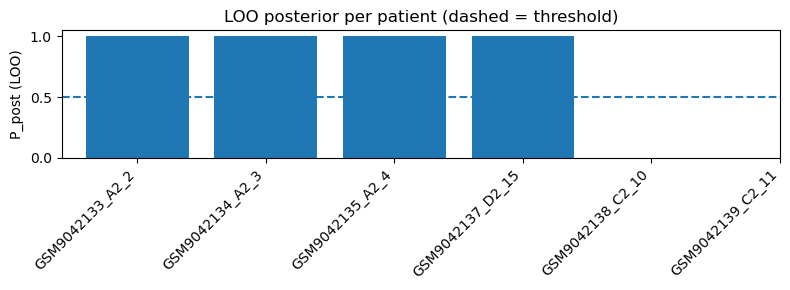

In [60]:
import matplotlib.pyplot as plt

order = patient_summary.sort_values(["patient_label","P_post_LOO"], ascending=[True, False]).index
ids = patient_summary.loc[order,"patient_id"].to_numpy()
pp  = patient_summary.loc[order,"P_post_LOO"].to_numpy()

plt.figure(figsize=(8,3))
plt.bar(range(len(pp)), pp)
plt.axhline(t_star, linestyle="--")
plt.xticks(range(len(pp)), ids, rotation=45, ha="right")
plt.ylabel("P_post (LOO)")
plt.title("LOO posterior per patient (dashed = threshold)")
plt.tight_layout(); plt.show()